In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

### Ridge regression shrinks parameter estimates, but the estimates never reach exactly 0. LASSO (Least Absolute Shrinkage and Selection Operator), on the other hand, is a model optimization mechanic that works by trying to force small parameter estimates to be equal to zero, effectively dropping them from the model. This can prevent overfitting, and also works as an embedded feature selection method. Lasso is extremely handy when you are dealing with thousands or hundreds of thousands of predictors and need to optimize processor time, or when you want to arrive at a simpler solution that is easier to interpret.

### Regularization based on the sum of the absolute weights is also called "L1 regularization".

### To summarize: Lasso works by iteratively fitting a model to the data while excluding one of the features. It then checks how well the model reproduces the data, and if the model fit is good enough (with "good enough" determined by  𝜆 ) then the excluded feature is deemed unnecessary and its  𝛽  is set to zero, effectively excluding it from the model. Otherwise, the excluded feature's  𝛽 is set using a combination of the correlation of the feature with the model residuals ( 𝜌𝑗 ) and  𝜆2  and a new iteration begins, using the newly-computed  𝛽  for the previously-excluded feature and excluding a new feature. This continues until the change in  𝛽  is less than a pre-determined threshold.

### Hopefully this demonstrates how lasso can both create overfitting-protection through shrinkage and create sparsity (many parameters set to 0) through feature selection. Let's see it at work, using the same dataset as previously.

In [2]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/credit-card-defaults.csv'
).iloc[:,1:].dropna()


In [3]:
df.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
df.shape

(10000, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [6]:
# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)


In [7]:
df.head(5)

,default,student,balance,income
0,-0.185599,-0.645936,-0.218835,0.813187
1,-0.185599,1.548141,-0.037616,-1.605496
2,-0.185599,-0.645936,0.492410,-0.131212
3,-0.185599,-0.645936,-0.632893,0.164031
4,-0.185599,-0.645936,-0.102791,0.370915


In [8]:
# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()


In [9]:
df_test.head(5)

,default,student,balance,income
5000,-0.185599,1.548141,-1.132387,-1.355403
5001,-0.185599,-0.645936,-0.423224,1.705896
5002,-0.185599,-0.645936,-0.464913,-0.363898
5003,-0.185599,-0.645936,0.803932,0.072979
5004,-0.185599,-0.645936,-1.051294,1.142702


In [10]:
df_train.head(5)

,default,student,balance,income
0,-0.185599,-0.645936,-0.218835,0.813187
1,-0.185599,1.548141,-0.037616,-1.605496
2,-0.185599,-0.645936,0.492410,-0.131212
3,-0.185599,-0.645936,-0.632893,0.164031
4,-0.185599,-0.645936,-0.102791,0.370915


In [11]:
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

In [12]:
print(Y_train)

[[ 0.81318727]
 [-1.60549572]
 [-0.13121225]
 ..., 
 [ 1.25649771]
 [-0.31587678]
 [-0.35094738]]


In [13]:
print(X_train)

       default   student   balance
0    -0.185599 -0.645936 -0.218835
1    -0.185599  1.548141 -0.037616
2    -0.185599 -0.645936  0.492410
3    -0.185599 -0.645936 -0.632893
4    -0.185599 -0.645936 -0.102791
5    -0.185599  1.548141  0.174106
6    -0.185599 -0.645936 -0.020388
7    -0.185599  1.548141 -0.055216
8    -0.185599 -0.645936  0.673329
9    -0.185599 -0.645936 -1.727085
10   -0.185599  1.548141 -1.727085
11   -0.185599  1.548141  0.796395
12   -0.185599 -0.645936 -1.237009
13   -0.185599 -0.645936 -0.472683
14   -0.185599 -0.645936  0.573907
15   -0.185599 -0.645936 -1.135317
16   -0.185599 -0.645936 -1.727085
17   -0.185599  1.548141 -0.636429
18   -0.185599 -0.645936 -0.722441
19   -0.185599 -0.645936  0.536909
20   -0.185599 -0.645936 -1.253740
21   -0.185599 -0.645936  0.245791
22   -0.185599 -0.645936  0.456039
23   -0.185599 -0.645936 -0.399823
24   -0.185599 -0.645936 -0.128518
25   -0.185599 -0.645936  0.040591
26   -0.185599 -0.645936 -0.397723
27   -0.185599 -0.64

In [14]:
# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3


In [15]:
df_train.head(5)

,default,student,balance,income,balance_student,balance_default,student_default,balance_sqrt,balance2,balance3
0,-0.185599,-0.645936,-0.218835,0.813187,0.141353,0.040616,0.119885,9.989052,9956.280924,9.934493e+05
1,-0.185599,1.548141,-0.037616,-1.605496,-0.058235,0.006981,-0.287334,9.998119,9992.478229,9.988719e+05
2,-0.185599,-0.645936,0.492410,-0.131212,-0.318066,-0.091391,0.119885,10.024590,10098.724506,1.014845e+06
3,-0.185599,-0.645936,-0.632893,0.164031,0.408808,0.117464,0.119885,9.968305,9873.822052,9.811331e+05
4,-0.185599,-0.645936,-0.102791,0.370915,0.066396,0.019078,0.119885,9.994859,9979.452390,9.969194e+05


In [16]:
df_train.shape

(5000, 10)

In [17]:
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]


In [18]:
print(X_train2)

       default   student   balance  balance_student  balance_default  \
0    -0.185599 -0.645936 -0.218835         0.141353         0.040616   
1    -0.185599  1.548141 -0.037616        -0.058235         0.006981   
2    -0.185599 -0.645936  0.492410        -0.318066        -0.091391   
3    -0.185599 -0.645936 -0.632893         0.408808         0.117464   
4    -0.185599 -0.645936 -0.102791         0.066396         0.019078   
5    -0.185599  1.548141  0.174106         0.269541        -0.032314   
6    -0.185599 -0.645936 -0.020388         0.013169         0.003784   
7    -0.185599  1.548141 -0.055216        -0.085482         0.010248   
8    -0.185599 -0.645936  0.673329        -0.434927        -0.124969   
9    -0.185599 -0.645936 -1.727085         1.115586         0.320546   
10   -0.185599  1.548141 -1.727085        -2.673770         0.320546   
11   -0.185599  1.548141  0.796395         1.232931        -0.147810   
12   -0.185599 -0.645936 -1.237009         0.799029         0.22

In [19]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [20]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.443633767129

Parameter estimates for the model with many features:
[  0.00000000e+00  -3.89351238e-01   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -2.77688887e-04
  -7.09158792e-07   3.48711577e+00]


In [21]:
print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

0.445532251512
0.438046634591


### Regularization parameter: Lasso
### The  𝜆  for lasso can var between 0 (no penalty, acts like OLS) and infinity. If  𝜆  is too large, all parameters will be set to zero.

### Create a plot below of how  𝑅2  varies across different values of  𝜆  for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

### Do lasso and ridge yield the same  𝑅2  for a given lambda value?

### Submit your work and discuss the results with your mentor.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

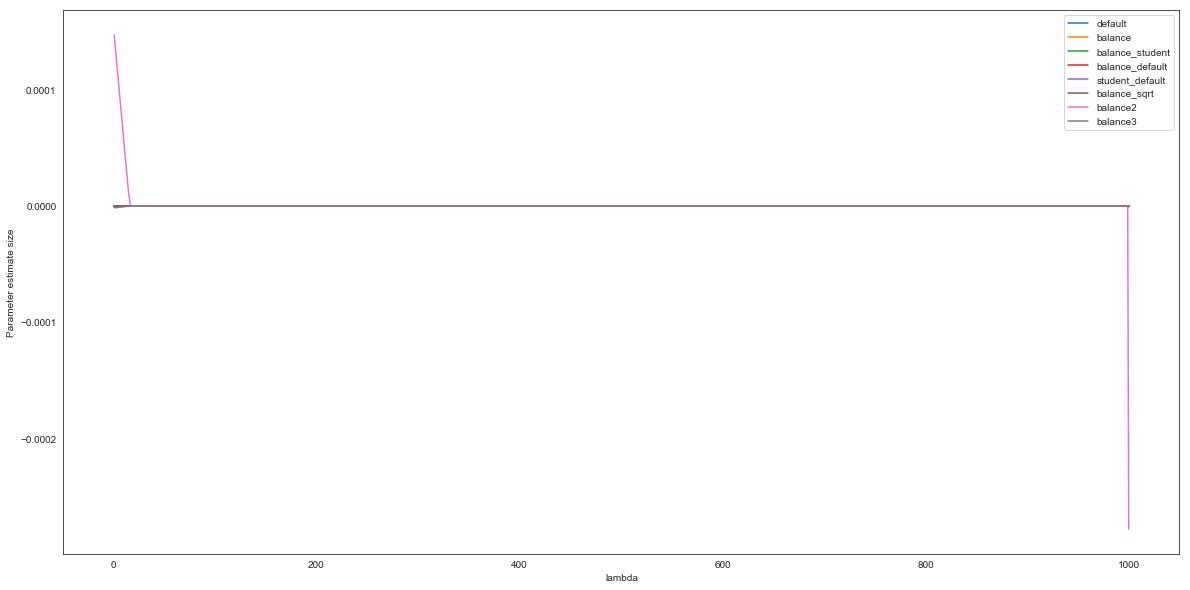

In [22]:
# Store estimates.
estimates = np.append(lassBig.coef_, [1000])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 1000, 2):
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(lassBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
plt.figure(figsize=(20,10))
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

In [23]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.57387391644
[  1.36988466e-02  -7.57859433e-01  -3.25298557e-04]
0.573946428961

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


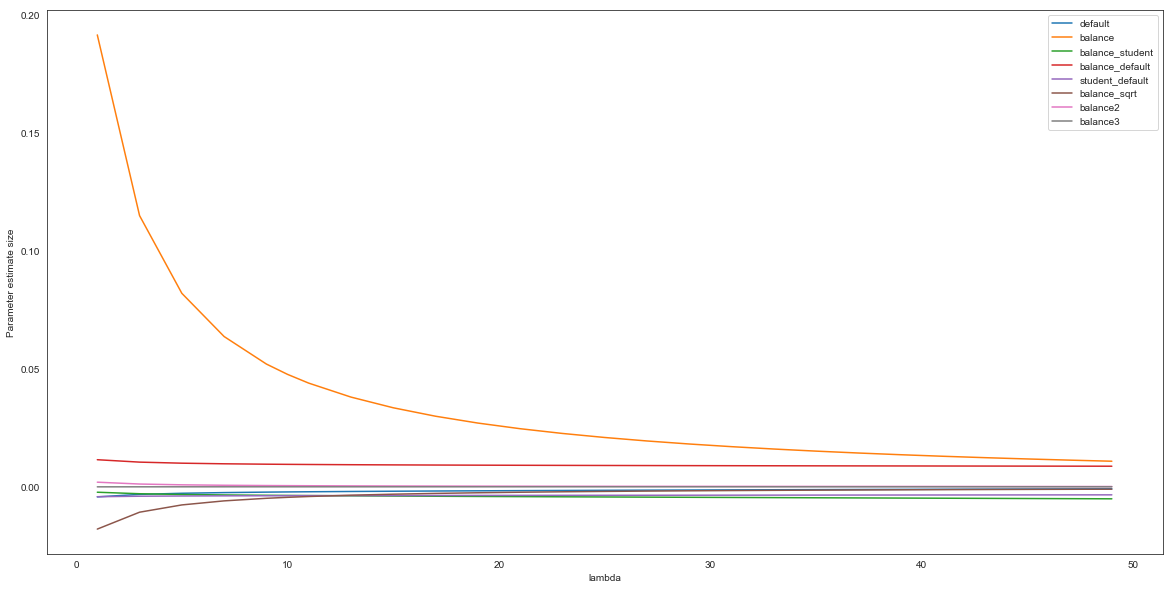

In [24]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
plt.figure(figsize=(20,10))
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()